<a href="https://colab.research.google.com/github/shpcode/Restricted-Boltzmann-Machine-RBM-/blob/main/RBM_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
from torchvision.transforms import ToTensor
import itertools
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# getting data
IMAGE_SIZE = 28
# composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

composed = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
            ])

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class RBM:
  def __init__(self, n_visible, n_hidden):
    # hyper parameters
    self.n = n_visible
    self.m = n_hidden
    self.h_all = self.combi()
    self.sig = nn.Sigmoid()
    self.softplus = nn.Softplus()


  def init(self,betha):
    # model paramerers initialization
    w = betha*nn.Parameter(torch.nn.init.normal_(torch.empty(self.n, self.m),mean=0.0, std=1))
    b = betha*nn.Parameter(torch.nn.init.normal_(torch.empty(1     , self.n),mean=0.0, std=0))
    c = betha*nn.Parameter(torch.nn.init.normal_(torch.empty(1     , self.m),mean=0.0, std=1))
    return w,b,c

  def combi(self):
    lst = list(itertools.product([0, 1], repeat=self.m))
    return torch.tensor(lst).float()

  def prob_h_given_v(self, visible_states,w,c): # p(h|V)
    return self.sig(torch.matmul(visible_states,w)+c)

  def prob_v_given_h(self,hidden_states,w,b):   # p(v|h)
    return self.sig(torch.matmul(hidden_states,w.transpose(1,0))+b)

############ constractive_divergence #############################
  def cd_update(self, lr,cd_k , visible_input,w,b,c):

    batch_size = torch.tensor( visible_input.shape[0], dtype=float)

  ## positive phase

    h_probs = self.prob_h_given_v(visible_input,w,c)
    h_0 = torch.bernoulli (h_probs )

    positive_grads = torch.matmul(torch.transpose(visible_input,2,1),h_0)

    h_states = h_0
  # Contrastive Divergence iterations

    for step in range(cd_k):
      v_probs  = self.prob_v_given_h(h_states,w,b)
      v_states = torch.bernoulli(v_probs)
      h_probs  = self.prob_h_given_v(v_states,w,c)
      h_states = torch.bernoulli(h_probs)


    negative_grads = torch.matmul(torch.transpose(v_states,2,1), h_states)

  # compute grad

    w = w + lr* (positive_grads - negative_grads).sum(0)
    b = b + lr* (visible_input - v_states ).sum(0)
    c = c + lr* (h_0 -h_states).sum(0)

    return w, b, c

  def free_energy( self,input, w,b,c):
    v_bias = torch.matmul(input,torch.t(b)).squeeze()
    alpha = torch.matmul(input,w).squeeze() + torch.repeat_interleave(c,input.shape[0],0)
    return -(self.softplus(alpha).sum(1) + v_bias ).mean()

  def log_z(self,w,b,c):
    exponent = []
    for i in range(self.h_all.shape[0]):

      h_bias = torch.matmul(self.h_all[i,:],torch.t(c)).squeeze()
      alpha = (torch.matmul(w,self.h_all[i,:]) + b)
      exponent.append([h_bias +  self.softplus(alpha).sum()])

    expo = torch.tensor(exponent) ; expo_m = expo.max()
    return torch.log(torch.exp(expo-expo_m).sum()) + expo_m

  def reconstruct(self,input,w,b,c):
    hidden_probs  = self.prob_h_given_v(input,w,c)
    hidden_states = torch.bernoulli ( hidden_probs)
    visible_probs = self.prob_v_given_h(hidden_states,w,b)
    return (visible_probs)

  def reconstruct_error(self, input,w,b,c):
    hidden_probs  = self.prob_h_given_v(input,w,c)
    hidden_states = torch.bernoulli ( hidden_probs)
    visible_probs = self.prob_v_given_h(hidden_states,w,b)
    return torch.mean(torch.square(input-visible_probs)).detach().numpy()

In [ ]:
def shuffel(input):
  rand_input = torch.zeros_like(input)
  for i in range(IMAGE_SIZE*IMAGE_SIZE):
    pixel = input[:,0,i]
    rand_pixel = pixel[torch.randperm(50)]
    rand_input[:,0,i] = rand_pixel
  return rand_input

In [ ]:
betha=0.001
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)
for valid,bla in validation_loader:
  valid = torch.flatten(valid,start_dim=2,end_dim=3)
  break

rbm = RBM(n_visible=IMAGE_SIZE**2, n_hidden=16)

w,b,c = rbm.init(betha)

In [ ]:
  lr=0.01
  LL=[]
  cd_k = 4

  error =[]
  epochs=10
  i=-1;
  for epoch in range(epochs):

    #lr = lr/(1+epoch)
    for x, y in train_loader:

      input= torch.flatten(x,start_dim=2,end_dim=3)
      input= shuffel(input)
      i = i+1
      if i==200 or i%500 == 0:
        LL.append([cd_k, -rbm.free_energy(valid,w,b,c) - rbm.log_z(w,b,c) ])
        print(i)

      w,b,c= rbm.cd_update(lr/(2*epoch+1), cd_k , input,w,b,c)
      b = torch.zeros(b.shape)

0
200
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500


In [ ]:
ll = np.asarray(LL)
np.save('shuffel-neg-ll',ll)

RuntimeError: ignored

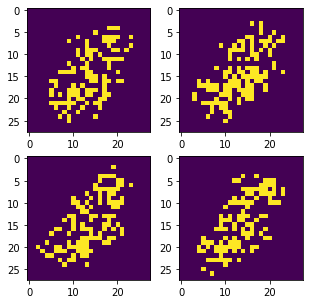

In [ ]:
f, axarr = plt.subplots(2,2)

f.set_figheight(5); f.set_figwidth(5)

axarr[0,0].imshow(input[6,:,:].reshape(IMAGE_SIZE,IMAGE_SIZE))
axarr[0,1].imshow(input[2,:,:].reshape(IMAGE_SIZE,IMAGE_SIZE))
axarr[1,0].imshow(input[3,:,:].reshape(IMAGE_SIZE,IMAGE_SIZE))
axarr[1,1].imshow(input[45,:,:].reshape(IMAGE_SIZE,IMAGE_SIZE))
plt.savefig('data')

In [ ]:
x= 1* torch.flatten(validation_dataset[25][0])\
+ torch.normal(torch.zeros(IMAGE_SIZE**2),std=0.2)

f, axarr = plt.subplots(1,7)

f.set_figheight(15)
f.set_figwidth(15)
#plt.imshow(x.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axarr[0].imshow(x.reshape(IMAGE_SIZE,IMAGE_SIZE))
j=0
for i in range(120):
  x = rbm.reconstruct(x,w,b,c)
  if i%20==0:
    j=j+1
    im=x.detach().numpy()
    axarr[j].imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE))
    axarr[j].set_title('%i gibbs sampled'%i)

plt.savefig('num-generat')

In [ ]:
plt.plot(np.asarray(LL)[:,1])
plt.ylabel('neg-ll')
plt.xlabel('updates')
plt.savefig('nn-ll')

In [ ]:
-rbm.free_energy(valid[1,0,:],w,b,c)-  rbm.log_z(w,b,c)

In [ ]:

x.shape

In [ ]:
x = torch.randint(low=0,high=2, size=(1,IMAGE_SIZE**2)).float()
# x=torch.flatten(validation_dataset[21][0]).unsqueeze(0)
chain = 10000
for step in range(chain):
  x = rbm.reconstruct(x,w,b,c)
x=x.detach().numpy()
plt.imshow(x.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [ ]:
# # plot lines
# plt.plot(LL[torch.where(LL[:,0]==1)][:,1].numpy(), label = "cd_k=1")
# plt.plot(LL[torch.where(LL[:,0]==2)][:,1].numpy(), label = "cd_k=2")
# plt.plot(LL[torch.where(LL[:,0]==4)][:,1].numpy(), label = "cd_k=4")
# plt.plot(LL[torch.where(LL[:,0]==6)][:,1].numpy(), label = "cd_k=6")
# plt.legend()
# plt.xlabel('epcohcs')
# plt.ylabel('LL')
# plt.xticks([0,20,40,60,80],[0,2000,4000,6000,8000])
# plt.show()